In [ ]:

from pyspark.sql import SparkSession
from pyspark.sql.functions  import *
from pyspark.sql import *
from pyspark.sql.types import *
import pandas as pd

spark=(SparkSession
       .builder
       .appName("ProblemasSpark")
       .getOrCreate())

In [ ]:
padron = spark.read\
.option("header", "true")\
.option("delimiter", ";")\
.option("inferSchema", "true")\
.option("quote", "\"")\
.csv("C:/PracticaPadron/PadronMadrid.csv")

In [ ]:
padron.show(truncate=True)

In [ ]:
#tratamiento de los datos
padron1=padron.withColumn("DESC_DISTRITO",trim("DESC_DISTRITO"))
padron2=padron1.withColumn("DESC_BARRIO",trim("DESC_BARRIO"))
padrondf=padron2.na.fill(value=0)
padrondf.show()
padrondf.cache()


In [ ]:
padrondf.printSchema()

In [ ]:
#Enumera todos los barrios diferentes
padrondf.select("DESC_BARRIO").distinct().show()


In [ ]:
#Crea una vista temporal de nombre "padron" y a través de ella cuenta el número de barrios diferentes que hay.
padrondf.createOrReplaceTempView("padron")
spark.sql("SELECT COUNT(DISTINCT DESC_BARRIO) FROM padron ").show()



In [ ]:
#Crea una nueva columna que muestre la longitud de los campos de la columna DESC_DISTRITO y que se llame "longitud"
padrondf=padrondf.withColumn("Longitud",length(col("DESC_DISTRITO")))
padrondf.show(truncate=False)


In [ ]:
#Crea una nueva columna que muestre el valor 5 para cada uno de los registros de la tabla.
padrondf=padrondf.withColumn("Cinco",lit(5))
padrondf.show()

In [ ]:
#Borra esta columna.
padrondf=padrondf.drop('Cinco')
padrondf.show()

In [ ]:
#Particiona el DataFrame por las variables DESC_DISTRITO y DESC_BARRIO.
padron_particionado=padrondf.repartition("DESC_DISTRITO","DESC_BARRIO")
padron_particionado.show()

In [ ]:
#Almacénalo en caché. Consulta en el puerto 4040 (UI de Spark) de tu usuario local el estado de los rdds almacenados.
padron_particionado_cacheado=padron_particionado.cache()

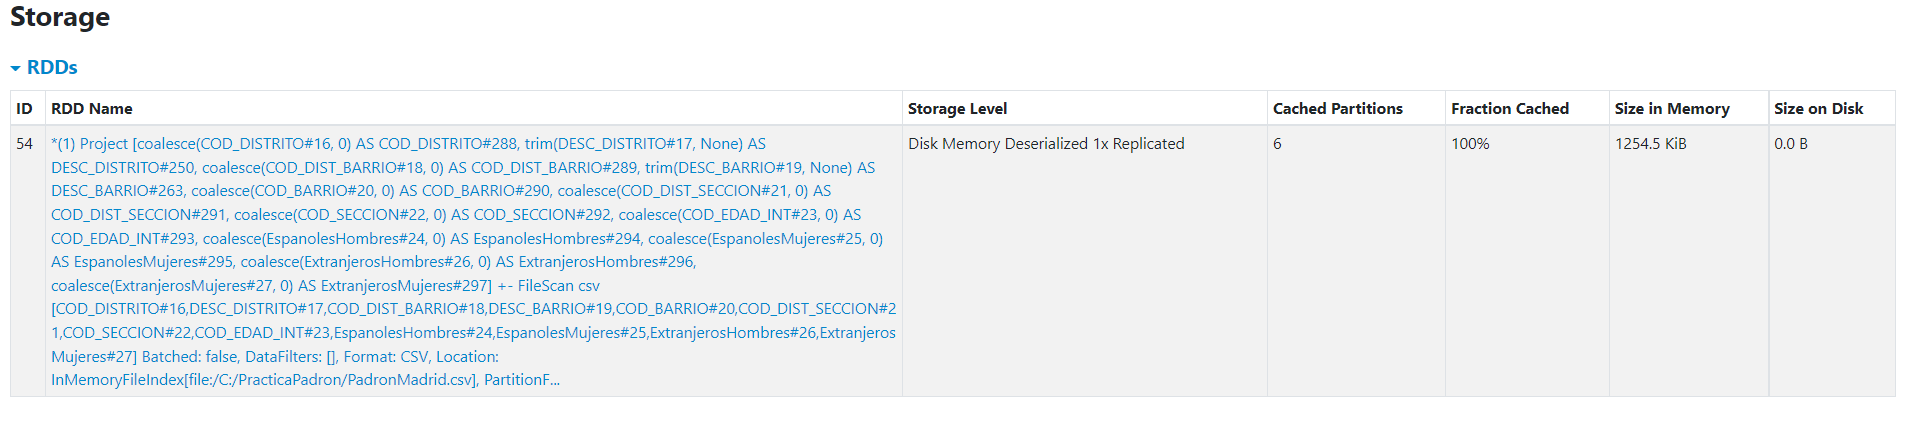

In [ ]:
#Lanza una consulta contra el DF resultante en la que muestre el número total de "espanoleshombres", "espanolesmujeres", extranjeroshombres" y "extranjerosmujers" 
#para cada barrio de cada distrito. Las columnas distrito y barrio deben ser las primeras en aparecer en el show. Los resultados deben estar ordenados en orden de más a menos 
#según la columna "extranjerosmujeres" y desempatarán por la columna "extranjeroshombres".

spark.sql("""SELECT DESC_DISTRITO,DESC_BARRIO,count(espanoleshombres) AS HomEsp,count(espanolesmujeres) AS MujEsp,count(extranjeroshombres) AS ExtHom,count(extranjerosmujeres) AS ExtMuj from padron GROUP BY DESC_DISTRITO,DESC_BARRIO 
         ORDER BY ExtMuj DESC, ExtHom """).show()


In [ ]:
#Elimina el registro en cach
padron_particionado_cacheado.unpersist()

In [ ]:
#Crea un nuevo DataFrame a partir del original que muestre únicamente una columna con DESC_BARRIO, otra con DESC_DISTRITO y otra con el número total de "espanoleshombres" 
#residentes en cada distrito de cada barrio. Únelo (con un join) con el DataFrame original a través de las columnas en común.

padron_unir=padrondf.groupby("DESC_DISTRITO","DESC_BARRIO").agg(sum('espanoleshombres').alias("sumaEspanoles"))
padron_unir.show()
padron_join=padrondf.join(padron_unir, on = ["DESC_DISTRITO","DESC_BARRIO"])
                        
padron_join.show()

In [ ]:
#Repite la función anterior utilizando funciones de ventana. (over(Window.partitionBy.....)).

w=Window().partitionBy("DESC_DISTRITO","DESC_BARRIO")
padron_window=padrondf.withColumn("SumaEspanoles",sum("espanoleshombres").over(w))
padron_window.show()

In [ ]:
#Mediante una función Pivot muestra una tabla (que va a ser una tabla de contingencia) que contenga los valores totales ()la suma de valores) de espanolesmujeres para cada distrito y 
#en cada rango de edad (COD_EDAD_INT). Los distritos incluidos deben ser únicamente CENTRO, BARAJAS y RETIRO y deben figurar como columnas . 

padron_pivot = padrondf.where((col("DESC_DISTRITO") == "CENTRO") | (col("DESC_DISTRITO") == "BARAJAS") | (col("DESC_DISTRITO") == "RETIRO") )\
.groupBy( "COD_EDAD_INT").pivot("DESC_DISTRITO")\
.agg(sum(col("Espanolesmujeres")))\
.orderBy(col("COD_EDAD_INT").asc())


padron_pivot.show()



In [ ]:
#Utilizando este nuevo DF, crea 3 columnas nuevas que hagan referencia a qué porcentaje de la suma de "espanolesmujeres"
#en los tres distritos para cada rango de edad representa cada uno de los tres distritos. Debe estar redondeada a 2 decimales.
#Puedes imponerte la condición extra de no apoyarte en ninguna columna auxiliar creada para el caso.


spark.sql(""" SELECT COD_EDAD_INT, sum(espanolesmujeres) from padron GROUP BY COD_EDAD_INT ORDER BY COD_EDAD_INT ASC""").show()


In [ ]:
padron_porc = padron_pivot.withColumn("suma", col("BARAJAS")+col("CENTRO")+ col("RETIRO"))\
.withColumn("PorcBARAJAS", col("BARAJAS")/col("suma")*100)\
.withColumn("PorcCENTRO", col("CENTRO")/col("suma")*100)\
.withColumn("PorcRETIRO", col("RETIRO")/col("suma")*100)\
.drop("suma")



padron_porc.show()

In [ ]:
#Guarda el archivo csv original particionado por distrito y por barrio (en ese orden) en un directorio local. Consulta el 
#directorio para ver la estructura de los ficheros y comprueba que es la esperada.

padrondf.write.option("header",True).partitionBy("DESC_DISTRITO", "DESC_BARRIO").mode('overwrite').format("csv").save("C:/PracticaPadron")

In [ ]:
padrondf.write.option("header",True).partitionBy("DESC_DISTRITO", "DESC_BARRIO").mode('overwrite').format("parquet").save("C:/ParquetPadron")